In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, roc_auc_score, f1_score, mean_absolute_error, classification_report 
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

Análise Exploratória dos Dados

In [2]:
data_location = "../Projeto-Integrador-III--Fraude-Cartao-Credito/Data/card_transdata.csv"
data = pd.read_csv(data_location, sep = ",")

In [3]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Verificando se há dados nulos

In [4]:
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [5]:
data.fraud.unique()

array([0., 1.])

In [6]:
print('\nConjunto de dados, linhas e colunas\n')
print('The shape of the data set is:',data.shape)
print('\n---------------------------------------------\n')

print('\nCheck valores nulos\n')
print('Checking for missing values: \n')
print(pd.isnull(data).sum())
print('\n---------------------------------------------\n')

print('\nEstatísticas\n')
print(data.describe())
print('\n---------------------------------------------\n')

print('\nInformações do dataset\n')
print(data.info())
print('\n---------------------------------------------\n')

print('\nCheck balanceamento da target fraud\n')
print(data['fraud'].value_counts())
print('\n---------------------------------------------\n')


Conjunto de dados, linhas e colunas

The shape of the data set is: (1000000, 8)

---------------------------------------------


Check valores nulos

Checking for missing values: 

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

---------------------------------------------


Estatísticas

       distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985  

Observando a distribuição dos dados

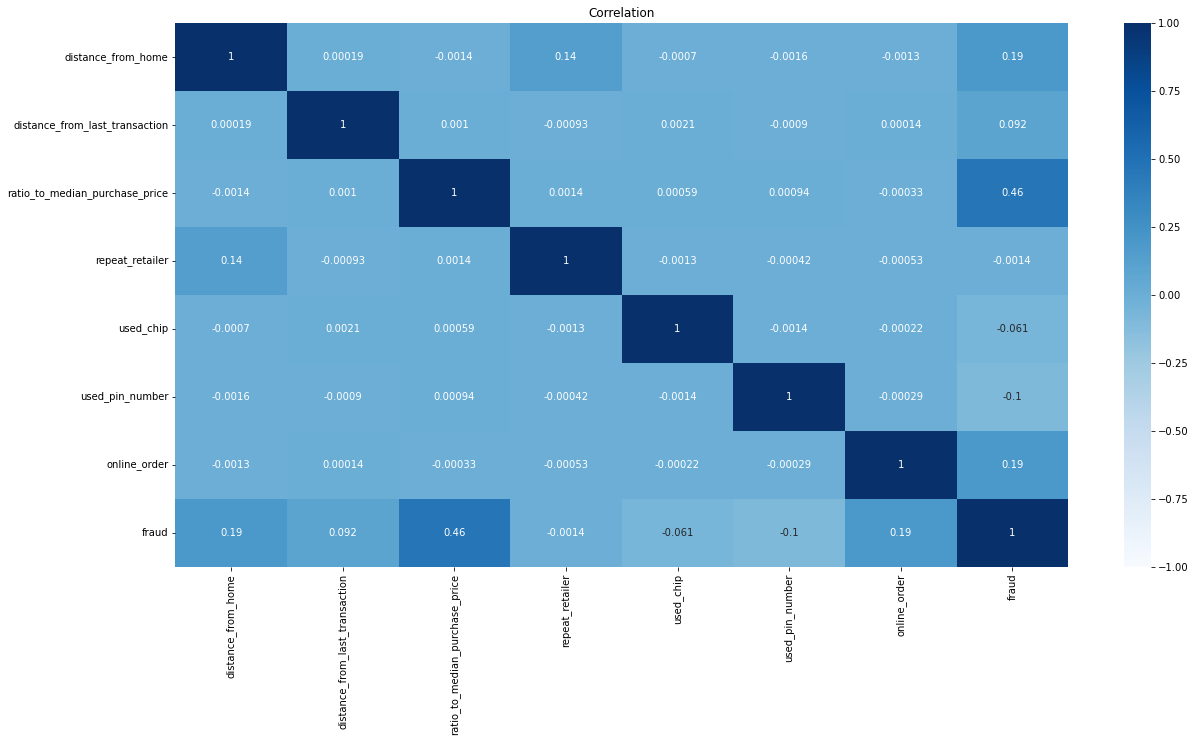

In [7]:
# Quais variáveis estão mais correlacionadas com a variável target?
plt.figure(figsize = (20,10))
plt.title('Correlation')
sns.heatmap(data.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
           );
plt.savefig("Correlation1.png", dpi = 600 )

# Balanceamento da variável target

In [8]:
data['fraud'].value_counts(normalize = True)

0.0    0.912597
1.0    0.087403
Name: fraud, dtype: float64

In [9]:
data.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

Verificamos que nesse conjunto apenas 8% dos dados são de cartões fraudados

Para resolver o problema do balanceamento vamos primeiramente criar dois datasets, um para os dados com frades e outro com dados sem fraude

In [10]:
no_fraud=data[data.fraud == 0]
fraud=data[data.fraud == 1]

Pegando uma amostra de 5000 para cada cada dataset, com fraude e sem fraude

In [11]:
dt_no_fraude_sample=no_fraud.sample(n=5000)
dt_fraude_sample=fraud.sample(n=5000)

Criação de um novo dataset com as amostras criadas anteriormente

In [12]:
data_fraud=pd.concat([dt_no_fraude_sample,dt_fraude_sample],axis=0)

In [13]:
data_fraud['fraud'].value_counts(normalize = True)

0.0    0.5
1.0    0.5
Name: fraud, dtype: float64

In [14]:
data_fraud.shape

(10000, 8)

In [15]:
data_fraud.corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,-0.022470,-0.073730,0.165120,-0.116170,-0.026084,0.061280,0.227086
distance_from_last_transaction,-0.022470,1.000000,-0.054522,-0.000951,-0.037935,-0.024314,0.028733,0.126921
ratio_to_median_purchase_price,-0.073730,-0.054522,1.000000,-0.041835,0.026800,-0.081674,0.121229,0.474543
repeat_retailer,0.165120,-0.000951,-0.041835,1.000000,-0.023149,-0.000772,0.079116,0.008131
used_chip,-0.116170,-0.037935,0.026800,-0.023149,1.000000,-0.005782,-0.035333,-0.117459
used_pin_number,-0.026084,-0.024314,-0.081674,-0.000772,-0.005782,1.000000,-0.081191,-0.225034
online_order,0.061280,0.028733,0.121229,0.079116,-0.035333,-0.081191,1.000000,0.386532
fraud,0.227086,0.126921,0.474543,0.008131,-0.117459,-0.225034,0.386532,1.000000


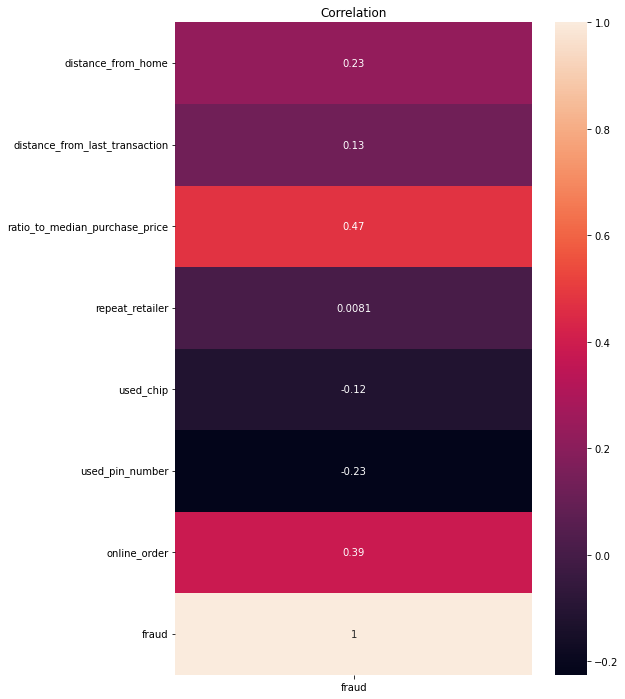

In [16]:
plt.figure(figsize = (8,12))
plt.title('Correlation')
sns.heatmap(data_fraud.corr()[['fraud']], 
            annot = True
           );
plt.savefig("Correlation2.png", dpi = 600 )

Observando a distribuição dos dados

In [17]:
#sns.pairplot(data_fraud, 
#            hue = 'fraud'
#             );

# Criação de uma lista vazia para armazenar as métricas dos modelos

In [18]:
data_all=[]

# Definição das matriz features, variável varget

Definindo a matriz de features e a variável target

In [19]:
X = data_fraud.drop(columns=['fraud'],axis=1)
y = data_fraud["fraud"]

# Split do dataset de treino e de teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=12)

Padronização das features do modelos de treino e de teste

In [21]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Modelo 1: Regressão Logística

Instanciando um objeto da classe LogisticRegression

In [22]:
lr = LogisticRegression()

Ajuste do modelo

In [23]:
lr.fit(X_train_std, y_train)

LogisticRegression()

Visualização dos coeficientes

In [24]:
print(lr.coef_)
print(lr.intercept_)

[[ 2.56370205  1.40094633  5.30286509 -0.48952595 -0.56784117 -1.97273737
   2.09399744]]
[0.29449042]


Previsão da acurácia com o modelo treinado

In [25]:
score_train_lr = accuracy_score(y_train, lr.predict(X_train_std))
print('Score train: ', score_train_lr)

Score train:  0.938


Matriz de confusão do modelo de treino

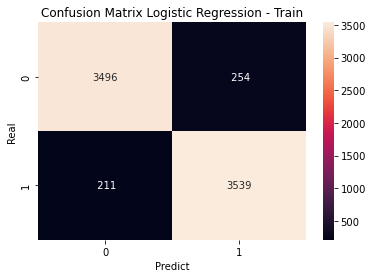

In [26]:
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Logistic Regression - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-LR-Train.png", dpi = 600 )

Observamos que há uma acurácia de 94%, dos 3750 casos positivos de fraud 3588 foram fraudes verdadeiras. Isso implica que nosso classificador está dizendo 95% das detecções de fraudes são positivas.

Previsão da acurácia com o modelo de teste

In [27]:
y_test_pred_lr = lr.predict(X_test_std)

Acurácia do modelo de teste

In [28]:
score_test_lr = accuracy_score(y_test, y_test_pred_lr)
print('Score test: ', score_test_lr)

Score test:  0.9392


Matriz de confusão do modelo de teste

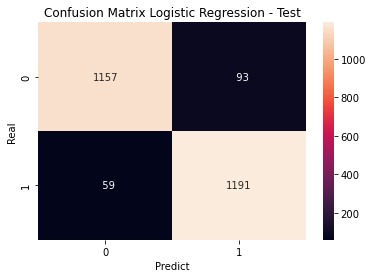

In [29]:
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Logistic Regression - Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-LR-test.png", dpi = 600 )

Observamos que há uma acurácia de 94%, dos 1250 casos positivos de fraud 1188 foram fraudes verdadeiras. Isso implica que nosso classificador está dizendo 95% das detecções de fraudes são positivas.

Métricas do modelo de teste

In [30]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_lr, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       0.95      0.93      0.94      1250
     Fraud 1       0.93      0.95      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



Inserindo as métricas na lista para armazenamento

In [31]:
m='Logistic Regression'
test_recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_test_pred_lr, pos_label=1)
test_auc_lr = auc(fpr_lr,tpr_lr)
f1_score_lr = f1_score(y_test, y_test_pred_lr)
data_all.append([m,score_train_lr,score_test_lr,test_recall_lr,test_auc_lr,f1_score_lr])

# Modelo 2: Randon Forest

Instanciando a classe Randon Forest

In [32]:
rf=RandomForestClassifier()

Treino do modelo usando os conjuntos de treinamento y_pred=clf.predict(X_test)

In [33]:
rf.fit(X_train_std, y_train)

RandomForestClassifier()

Previsão da acurácia com o modelo de teste

In [34]:
score_train_rf = accuracy_score(y_train, rf.predict(X_train_std))
print('Score train: ', score_train_rf)

Score train:  1.0


Atribuindo A variável y_test_pred a previsão

In [35]:
y_test_pred_rf = rf.predict(X_test_std)

Atribuindo a variável score_test a acurácia

In [36]:
score_test_rf = accuracy_score(y_test, y_test_pred_rf)
print('Score test: ', score_test_rf)

Score test:  0.9988


Matriz de confusão do modelo de treino

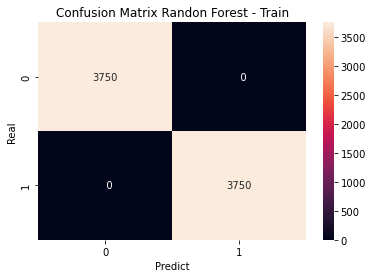

In [37]:
sns.heatmap(confusion_matrix(y_train, rf.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Randon Forest - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-RF-train.png", dpi = 600 )

Matriz de confusão do modelo de teste

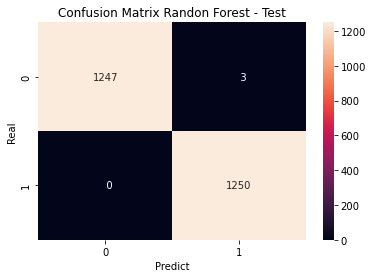

In [38]:
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Randon Forest - Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-RF-test.png", dpi = 600 )

Observando as métricas

In [39]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_rf, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      1.00      1.00      1250
     Fraud 1       1.00      1.00      1.00      1250

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



Inserindo as métricas na lista para armazenamento

In [40]:
m='Randon Forest'
test_recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_pred_rf, pos_label=1)
test_auc_rf = auc(fpr_rf,tpr_rf)
f1_score_rf = f1_score(y_test, y_test_pred_rf)
data_all.append([m,score_train_rf,score_test_rf,test_recall_rf,test_auc_rf,f1_score_rf])

# Modelo 3: KNeighborsRegressor

Escolha da escolher metrica (Euclidean,  Manhattan ou Chebyshev)
Escolher com quantos vizinhos a quantidade de vizinhos próximos pelo modelo de validação cruzada.

In [41]:
# Usamos cross validation co, 5 folds
kf = KFold(n_splits = 5, shuffle = True, random_state = 12)
scores_para_df = []
for i in range(1, 26):
# Em cada iteração, instanciamos o modelo com um hiperparâmetro diferente
    model_euclidean = KNeighborsClassifier(metric = 'euclidean', n_neighbors = i)
    model_manhattan = KNeighborsClassifier(metric = 'manhattan', n_neighbors = i)
    model_chebyshev = KNeighborsClassifier(metric = 'chebyshev', n_neighbors = i)
# cross_val_scores retorna uma matriz de 5 resultados,
# um para cada partição que automaticamente criou CV
    cv_scores = cross_val_score(model_euclidean, X_train_std, y_train, cv = kf)
    cv_scores2 = cross_val_score(model_manhattan, X_train_std, y_train, cv = kf)
    cv_scores3 = cross_val_score(model_chebyshev, X_train_std, y_train, cv = kf)
# Para cada valor de n_neighbours, criamos um dicionário com o valor
# de n_neighbours e a média das pontuações
    dict_row_score = { 'n_neighbors': i, 'euclidean': np.mean(cv_scores),'manhattan': np.mean(cv_scores2),'chebyshev': np.mean(cv_scores3)}

# Salvamos cada um na lista definida fora do loop
    scores_para_df.append(dict_row_score)

De acordo com os vizinhos próximos as 3 melhores accuracy das metricas estão grifadas em amarelo

In [42]:
df_scores = pd.DataFrame(scores_para_df)

In [43]:
df_scores.style.highlight_max(subset=['euclidean','manhattan','chebyshev'])

,n_neighbors,euclidean,manhattan,chebyshev
0,1,0.988667,0.989867,0.988133
1,2,0.987067,0.988533,0.986000
2,3,0.988933,0.989200,0.987067
3,4,0.988267,0.988533,0.986533
4,5,0.987333,0.987467,0.985467
5,6,0.986267,0.986800,0.985467
6,7,0.984800,0.985867,0.983733
7,8,0.984800,0.985467,0.984933
8,9,0.984533,0.984800,0.983467
9,10,0.984400,0.984667,0.983333


Conforme identificado acima qual melhor parâmetro de distância e vizinhos se aplica ao modelo.

In [44]:
knn = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 3)

Treino do modelo usando a distancia e métrica identificada

In [45]:
knn.fit(X_train_std, y_train);

Previsão com o modelo de teste

In [46]:
y_test_pred_knn = knn.predict(X_test_std)

Previsão valores e a acurácia

In [47]:
accuracy_score(y_test, y_test_pred_knn).round(4)

0.9892

In [48]:
score_train_knn = accuracy_score(y_train, knn.predict(X_train_std))
print('Score train: ', score_train_knn)

Score train:  0.9941333333333333


In [49]:
score_test_knn = accuracy_score(y_test, y_test_pred_knn)
print('Score test: ', score_test_knn)

Score test:  0.9892


Matriz de confusão modelo treino

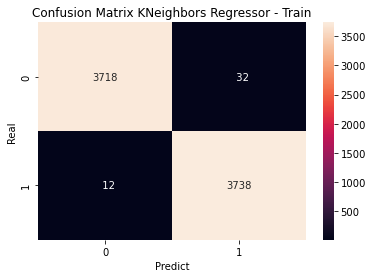

In [50]:
sns.heatmap(confusion_matrix(y_train, knn.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix KNeighbors Regressor - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-knn-train.png", dpi = 600 )

Matriz de confusão modelo teste

In [51]:
confusion_matrix(y_test,y_test_pred_knn)

array([[1231,   19],
       [   8, 1242]], dtype=int64)

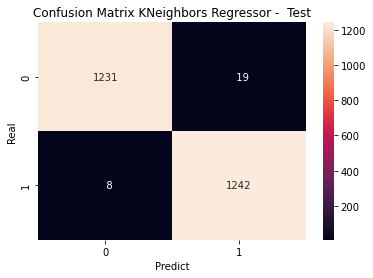

In [52]:
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix KNeighbors Regressor -  Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-knn-test.png", dpi = 600 )

Observando as métricas

In [53]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_knn, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       0.99      0.98      0.99      1250
     Fraud 1       0.98      0.99      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



Inserindo as métricas na lista para armazenamento

In [54]:
m='KNN'
test_recall_knn = recall_score(y_test, y_test_pred_knn, pos_label=1)
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_test_pred_knn, pos_label=1)
test_auc_knn = auc(fpr_knn,tpr_knn)
f1_score_knn = f1_score(y_test, y_test_pred_knn)
data_all.append([m,score_train_knn,score_test_knn,test_recall_knn,test_auc_knn,f1_score_knn])

# Modelo 4: Decision Tree Classifier

Intanciando a classe Decison Tree Classifier, definimos o random_state de 12

In [55]:
dt = DecisionTreeClassifier(random_state=12)

Treino do modelo 

In [56]:
dt.fit(X_train_std, y_train)

DecisionTreeClassifier(random_state=12)

Previsão valores e a acurácia

In [57]:
y_test_pred_dt = dt.predict(X_test_std)

Previsão acurácia de treino

In [58]:
score_train_dt = accuracy_score(y_train, dt.predict(X_train_std))
print('Score train: ', score_train_dt)

Score train:  1.0


Previsão acurácia de teste

In [59]:
score_test_dt = accuracy_score(y_test, y_test_pred_dt)
print('Score test: ', score_test_dt)

Score test:  0.9984


Imprimindo a media aboluta

In [60]:
mean_abs_dt = mean_absolute_error(y_test, y_test_pred_dt)
print('Mean Absolute Error: ', mean_abs_dt)

Mean Absolute Error:  0.0016


Criando a matriz de confusão modelo treino

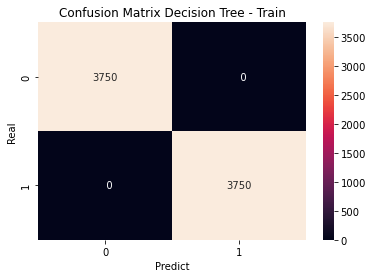

In [61]:
sns.heatmap(confusion_matrix(y_train, dt.predict(X_train_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Decision Tree - Train')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-DT-train.png", dpi = 600 )

Criando a matriz de confusão modelo teste

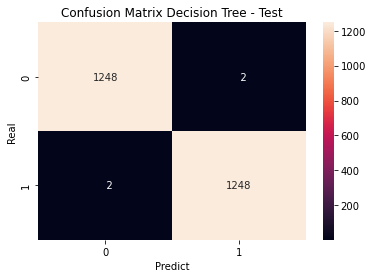

In [62]:
sns.heatmap(confusion_matrix(y_test, dt.predict(X_test_std)), 
            annot = True, 
            fmt = '4d'
           )

plt.title('Confusion Matrix Decision Tree - Test')
plt.xlabel('Predict')
plt.ylabel('Real');
plt.savefig("confusion-DT-test.png", dpi = 600 )

In [63]:
target_names=['No Fraud 0', 'Fraud 1']
report_class = classification_report(y_test, y_test_pred_dt, target_names=target_names)
print("Classification Report:\n----------------------\n", report_class)

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Fraud 0       1.00      1.00      1.00      1250
     Fraud 1       1.00      1.00      1.00      1250

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



Inserindo as métricas na lista para armazenamento

In [64]:
m='DT'
test_recall_dt = recall_score(y_test, y_test_pred_dt, pos_label=1)
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_test_pred_dt, pos_label=1)
test_auc_dt = auc(fpr_dt,tpr_dt)
f1_score_dt = f1_score(y_test, y_test_pred_dt)
data_all.append([m,score_train_dt,score_test_dt,test_recall_dt,test_auc_dt,f1_score_dt])

### Calculando as probabilidades para a previsão 

In [65]:
r_probs = [0 for _ in range (len(y_test))]
lr_probs = lr.predict_proba(X_test_std)
rf_probs = rf.predict_proba(X_test_std)
knn_probs = knn.predict_proba(X_test_std)
dt_probs = dt.predict_proba(X_test_std)

In [66]:
lr_probs = lr_probs[:,1]
rf_probs = rf_probs[:,1]
knn_probs = knn_probs[:,1]
dt_probs = dt_probs[:,1]

In [67]:
r_auc = roc_auc_score(y_test, r_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
dt_auc = roc_auc_score(y_test, dt_probs)

Imprimindo AUROC scores com os modelos Logistic Regression, Randon Forest e Decision Tree

In [68]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Logistic Regression: AUROC = %.3f' % (lr_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('KNeighbors Regressor: AUROC = %.3f' % (knn_auc))
print('Decision Tree: AUROC = %.3f' % (dt_auc))

Random (chance) Prediction: AUROC = 0.500
Logistic Regression: AUROC = 0.978
Random Forest: AUROC = 1.000
KNeighbors Regressor: AUROC = 0.997
Decision Tree: AUROC = 0.998


Calculando a Curva ROC dos modelos

In [69]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, rf_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

Plotando a curva ROC

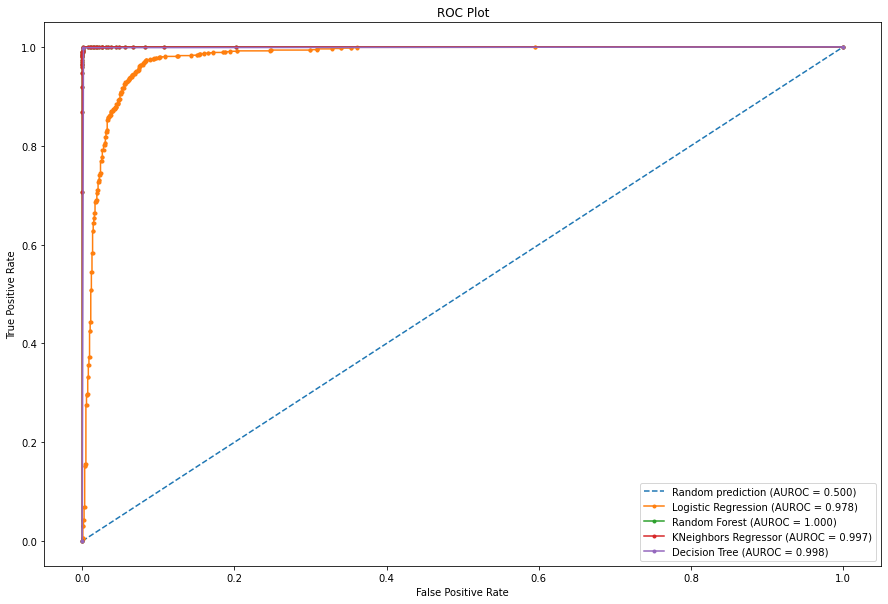

In [70]:
plt.figure(figsize = (15,10))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNeighbors Regressor (AUROC = %0.3f)' % knn_auc)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUROC = %0.3f)' % dt_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.savefig("ROC-plot.png", dpi = 600 )
plt.show()

### Resumo das métricas dos modelos

Atribuindo nome das colunas no dataframe de métricas e imprimindo as informações de todos modelos.

In [71]:
models=['Logistic','Randon Forest', 'KNeighbors','Decision Tree']
pd_scores=pd.DataFrame(data_all,columns=['model','train score','test score','test recall','test_auc','F1 Score'])
print(pd_scores)

                 model  train score  test score  test recall  test_auc  \
0  Logistic Regression     0.938000      0.9392       0.9528    0.9392   
1        Randon Forest     1.000000      0.9988       1.0000    0.9988   
2                  KNN     0.994133      0.9892       0.9936    0.9892   
3                   DT     1.000000      0.9984       0.9984    0.9984   

   F1 Score  
0  0.940016  
1  0.998801  
2  0.989247  
3  0.998400  


## Diagramas de Confiabilidade

Vizualização de quão bem calibradas as probabilidades previstas estão usando curvas de calibração nos modelos de treino

In [72]:
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (rf, "RandomForest"),
    (knn, "KNeighbors"),
    (gnb, "Naive Bayes"),
    (dt, "DecisionTree"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]



C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


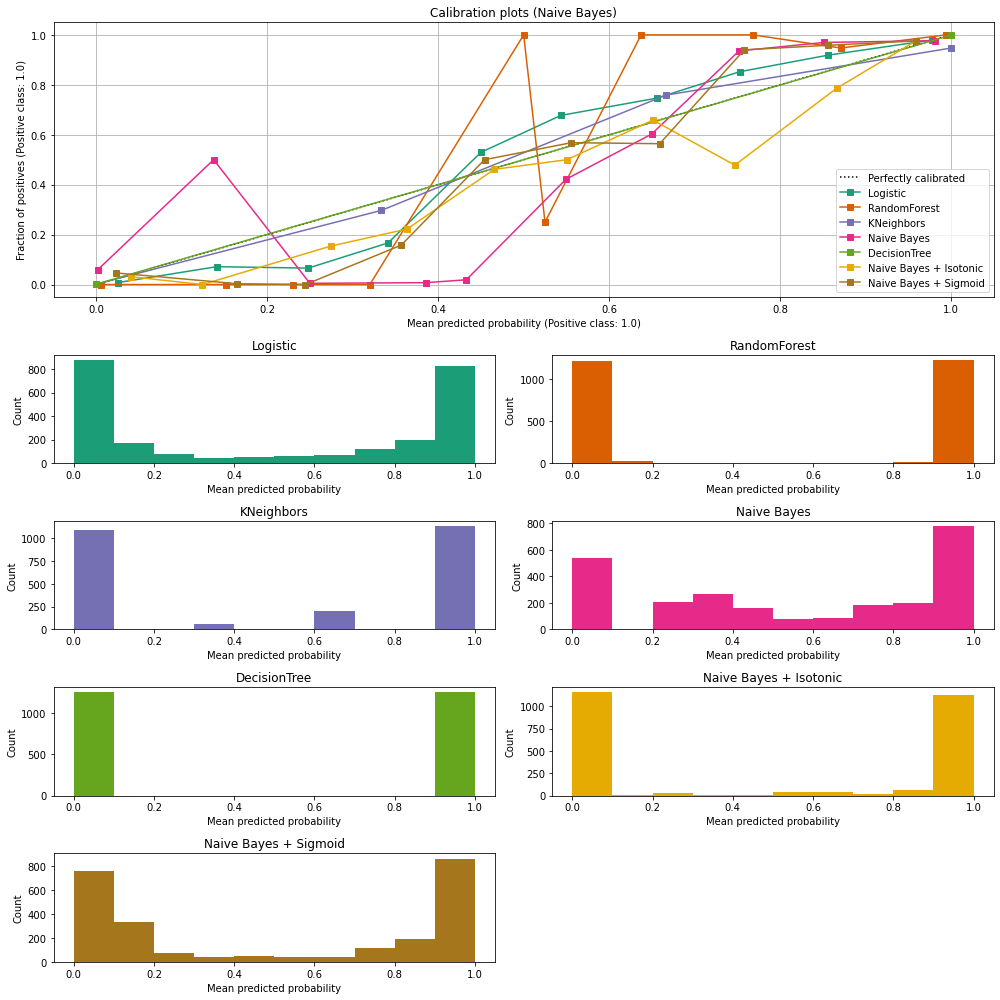

In [73]:
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.savefig("CalibrationDisplay-plot.png", dpi = 600 )
plt.show()
